# Import Librarys

In [1]:
import project
import pandas                   as pd
import numpy                    as np
import scikitplot               as skplt
from sklearn.model_selection    import StratifiedKFold
from lightgbm                   import LGBMClassifier

# Load the data

In [2]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']

df5 = pd.read_csv('../data/dataframe_steps/df5.csv')
x_val = pd.read_csv('../data/dataframe_steps/x_val_pp.csv')

x_train = df5[ cols_selected ]
y_train = df5['response']

x_val1 = x_val[ cols_selected ]
y_val = pd.read_csv('../data/dataframe_steps/y_val.csv')

In [3]:
# append dataframes for cross-validation
cv_x = pd.concat([x_train, x_val1])
cv_y = pd.concat([pd.DataFrame(y_train), y_val])

# dataset for cross validation
dataset = cv_x
dataset['response'] = cv_y

k = int(x_val.shape[0]*0.4)

# LGBMClassifier Model

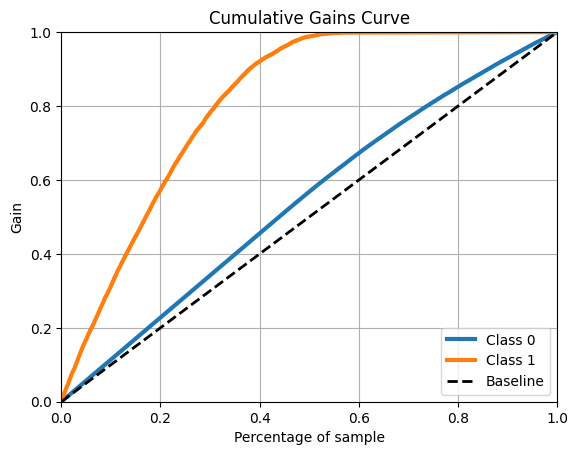

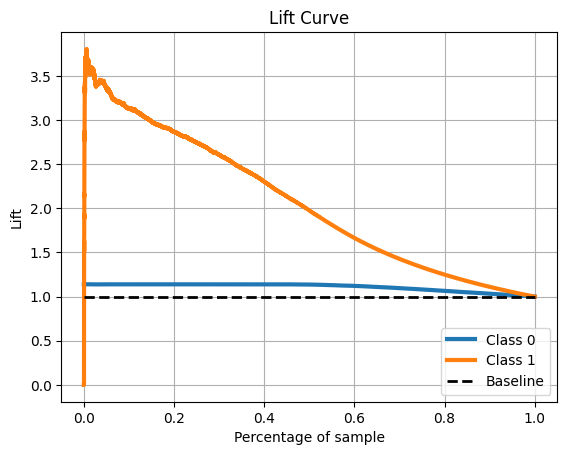

In [4]:
# model definition
lgbm_model = LGBMClassifier(random_state=0)
# model training
lgbm_model.fit( x_train, y_train )

# model prediction
yhat_lgbm = lgbm_model.predict_proba( x_val1 )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lgbm );

# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_lgbm);

In [5]:
insurance = project.ProjectFunctions()
lgbm_score = insurance.make_score(x_val, y_val, yhat_lgbm)

# compute precision at K
precision_at_n_k = insurance.precision_at_k( lgbm_score, k=k )
print( f'Precision at K: {precision_at_n_k}' )

# compute recall at K
recall_at_n_k = insurance.recall_at_k( lgbm_score, k=k )
print( f'Recall    at K: {recall_at_n_k}')

Precision at K: 0.2821345403260192
Recall    at K: 0.9207878398629844


In [6]:
skf = StratifiedKFold(n_splits=10)

model = lgbm_model

knn_cv = insurance.stratifield_cross_validation( x_data=cv_x, y_data=cv_y,dataset=dataset, skf=skf, model=model, sample_size=0.4)

fold :1 | precision 0.28193 | recall 0.92015
fold :2 | precision 0.28632 | recall 0.93449
fold :3 | precision 0.28186 | recall 0.91993
fold :4 | precision 0.28691 | recall 0.93642
fold :5 | precision 0.28213 | recall 0.92079
fold :6 | precision 0.28094 | recall 0.91693
fold :7 | precision 0.28337 | recall 0.92486
fold :8 | precision 0.28232 | recall 0.92143
fold :9 | precision 0.28298 | recall 0.92357
fold :10 | precision 0.28239 | recall 0.92164


# Hyperparameter Finetunning

In [7]:
from skopt import dummy_minimize

In [8]:
mdl = LGBMClassifier(random_state=42)
mdl.fit( x_train, y_train )

LGBMClassifier(random_state=42)

In [61]:
from sklearn.metrics import top_k_accuracy_score
p = mdl.predict_proba(x_val1)[:,1]

learning_rate => # quanto cada arvore vai contribuir para combinacao de arvores que o modelo vai criar

num_leaves => # numero maximo de folhas em cada arvore

min_child_samples => # numero de exemplos em cada nó

subsample => # cada vez que for criar uma nova arvore ele vai fazer uma amostra dos nossos dados, 
dando diversidade para as arvores evitando overfiting

colsample_bytree => # não vai deixar todas as variaveis disponiveis para todas as arvores

subsample_freq => # a cada arvore vamos tirar uma amostra diferentes pros dados

In [80]:
def training_model(params):
    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3] 
    colsample_bytree = params[4] 
    
    print(params, '\n')
    
    mdl = LGBMClassifier(learning_rate=learning_rate, num_leaves=num_leaves, 
                         min_child_samples=min_child_samples, subsample=subsample, 
                         colsample_bytree=colsample_bytree, random_state=0, subsample_freq=1,
                         n_estimators=1000)
    mdl.fit(x_train, y_train)
    
    p = mdl.predict_proba(x_val1)[:,1]
    
    data = x_val1.copy()
    data['response'] = y_val.copy()
    data['score'] = p.tolist()
    data = data.sort_values('score', ascending=False)
    data = data.reset_index( drop=True )
    data['ranking'] = data.index + 1
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    precision = data.loc[k, 'precision_at_k']
    
    return -precision

In [81]:
space = [(1e-3, 1e-1, 'log-uniform'), # learning_rate
         (2, 128), # num_leaves
         (1, 100), # min_child_samples
         (0.05, 1.0), # subsample
         (0.1, 1.0)] # colsample bytree

In [82]:
resultado = dummy_minimize(training_model, space, random_state=1, verbose=1, n_calls=30)

Iteration No: 1 started. Evaluating function at random point.
[0.09871192514273254, 74, 10, 0.3372159440002478, 0.23208030173540176] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 13.4910
Function value obtained: -0.2784
Current minimum: -0.2784
Iteration No: 2 started. Evaluating function at random point.
[0.001529949829431263, 78, 72, 0.3782826906908954, 0.457090726807603] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 11.6862
Function value obtained: -0.2808
Current minimum: -0.2808
Iteration No: 3 started. Evaluating function at random point.
[0.01195730942971637, 128, 19, 0.5483207515942279, 0.49910760440160107] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 13.1632
Function value obtained: -0.2822
Current minimum: -0.2822
Iteration No: 4 started. Evaluating function at random point.
[0.0028784217488024557, 16, 51, 0.9182639233502714, 0.5114843271882895] 

Iteration No: 4 ended. Evaluation done at random point.
T

In [83]:
resultado.x

[0.007267702383040958, 96, 97, 0.7894697745197069, 0.7443734643715278]

In [ ]:
0.2827
[0.007267702383040958, 96, 97, 0.7894697745197069, 0.7443734643715278]

In [84]:
from skopt import gp_minimize

In [85]:
resultados_gp = gp_minimize(training_model, space, random_state=1, verbose=1, n_calls=30, n_random_starts=10)

Iteration No: 1 started. Evaluating function at random point.
[0.09871192514273254, 120, 14, 0.9990884895579377, 0.3124800792567785] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 15.3016
Function value obtained: -0.2782
Current minimum: -0.2782
Iteration No: 2 started. Evaluating function at random point.
[0.006210998932353835, 51, 67, 0.9387621172657304, 0.8616798250174156] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 20.0070
Function value obtained: -0.2830
Current minimum: -0.2830
Iteration No: 3 started. Evaluating function at random point.
[0.004232013397179603, 68, 45, 0.2680983530433343, 0.5809725180523154] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 14.5620
Function value obtained: -0.2822
Current minimum: -0.2830
Iteration No: 4 started. Evaluating function at random point.
[0.0672858974212934, 60, 44, 0.9421713999524447, 0.8005503127028804] 

Iteration No: 4 ended. Evaluation done at random point.
Time

In [86]:
resultados_gp.x

[0.006210998932353835, 51, 67, 0.9387621172657304, 0.8616798250174156]

0.2830
[0.006210998932353835, 51, 67, 0.9387621172657304, 0.8616798250174156]

In [87]:
from skopt.plots import plot_convergence

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

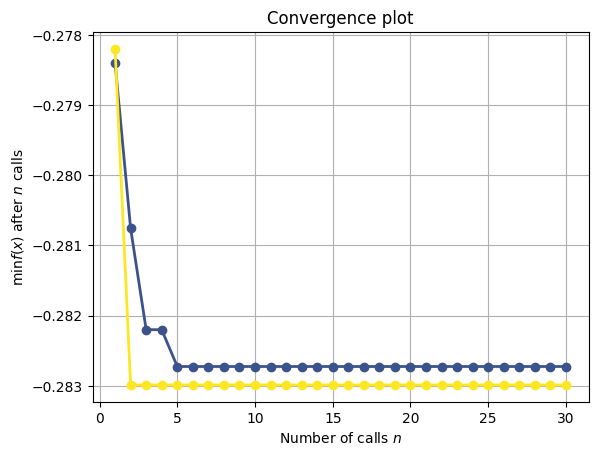

In [88]:
plot_convergence(resultado, resultados_gp)